# FCN

## 0. Paper

### Info
* Title: Fully Convolutional Networks for Semantic Segmentation 
* Author: Evan Shelhamer
* Task: Semantic Segmentation
* Link: https://arxiv.org/abs/1411.4038


### Features
* Dataset: Camvid, [link](https://www.kaggle.com/carlolepelaars/camvid)

### Reference
* https://www.kaggle.com/drnykterstein/camvid-semantic-segmentation
* https://github.com/petko-nikolov/pysemseg


## 1. Setting

In [1]:
import os
import sys
import time
from glob import glob
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import torchsummary

In [2]:
class CONFIG:
    num_classes = 32
    input_size = 128
    batch_size = 4
    epoch_size = 50
    base_dir = '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation'

## 2. Data

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, mode):
        self.inputs_dir = os.path.join(data_dir, mode)
        self.targets_dir = os.path.join(data_dir, f'{mode}_labels')
        self.inputs = sorted(glob(os.path.join(self.inputs_dir, '*.png')))
        self.targets = sorted(glob(os.path.join(self.targets_dir, '*.png')))
        self.class_dict = pd.read_csv(os.path.join(data_dir, 'class_dict.csv'))

        self.idx2rgb = self.class_dict[['r', 'g', 'b']].apply(lambda x : (x['r'], x['g'], x['b']), axis=1).to_dict()
        self.rgb2idx = {v:k for k,v in self.idx2rgb.items()}

        self.inputs_transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])

        self.targets_transform = transforms.Compose([
            transforms.Resize((128, 128))
        ])

    def __len__(self):
        return len(self.inputs)
    
    def mask2label(self, mask):
        mask = np.array(mask)
        label = np.zeros((CONFIG.input_size, CONFIG.input_size))
        for k, v in self.idx2rgb.items():
            label[np.all(mask==v, axis=-1)] = k
        label = torch.LongTensor(label)
        return label
    
    def label2mask(self, label):
        mask = torch.zeros((3, CONFIG.input_size, CONFIG.input_size))
        for k,v in self.idx2rgb.items():
            is_k = label == k
            for i in range(3):
                mask[i,:,:][is_k] = v[i]
        mask /= 255.0
        mask = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(mask)
        return mask

    
    def __getitem__(self, idx):
        x = self.inputs[idx]
        y = self.targets[idx]

        x = Image.open(x).convert('RGB')
        x = self.inputs_transform(x)
        y = Image.open(y).convert('RGB')
        y = self.targets_transform(y)

        y = self.mask2label(y)
        return x, y

In [4]:
data_path = os.path.join(CONFIG.base_dir, 'data/camvid.zip')
!unzip -q "{data_path}" -d "data"

In [4]:
train_data = Dataset('data', 'train')
val_data = Dataset('data', 'val')
test_data = Dataset('data', 'test')

In [5]:
train_loader = torch.utils.data.DataLoader(train_data, CONFIG.batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, CONFIG.batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, 1, shuffle=False)

In [6]:
x, y = next(iter(train_loader))
x.size(), y.size()

(torch.Size([4, 3, 128, 128]), torch.Size([4, 128, 128]))

## 3. Model

In [7]:
class FCN(nn.Module):
    def __init__(self, num_classes):
        super(FCN, self).__init__()
        self.vgg16 = torchvision.models.vgg16(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Conv2d(512, 4096, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(4096, 4096, kernel_size=1),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(4096, num_classes, kernel_size=1)
        )

    def _initialize_weights(self):
        self.classifier[0].weight.data = self.vgg16.classifier[0].weight.data.view(self.classifier[0].weight.size())
        self.classifier[3].weight.data = self.vgg16.classifier[3].weight.data.view(self.classifier[3].weight.size())


class FCN32(FCN):
    def forward(self, x):
        h, w = x.size()[2:]
        x = self.vgg16.features(x) # 1/32
        x = self.classifier(x)
        x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=True)
        return x


class FCN16(FCN):
    def __init__(self, num_classes):
        super().__init__(num_classes)
        self.score4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.upsample5 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=2, stride=2) # x2

    def forward(self, x):
        h, w = x.size()[2:]
        pool4 = self.vgg16.features[:-7](x) # 1/16
        pool5 = self.vgg16.features[-7:](pool4) # 1/32
        pool5 = self.upsample5(self.classifier(pool5))
        out = self.score4(pool4) + pool5
        out = F.interpolate(out, size=(h, w), mode='bilinear', align_corners=True)
        return out


class FCN8(FCN):
    def __init__(self, num_classes):
        super().__init__(num_classes)
        self.score3 = nn.Conv2d(256, num_classes, kernel_size=1)
        self.score4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.upsample5 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=2, stride=2)
        self.upsample4 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=2, stride=2)

    def forward(self, x):
        h, w = x.size()[2:]
        pool3 = self.vgg16.features[:-14](x) # 1/8
        pool4 = self.vgg16.features[-14:-7](pool3) # 1/16
        pool5 = self.vgg16.features[-7:](pool4) # 1/32

        pool5 = self.upsample5(self.classifier(pool5))
        pool4 = self.score4(pool4) + pool5
        pool4 = self.upsample4(pool4)
        pool3 = self.score3(pool3)
        
        out = pool3 + pool4
        out = F.interpolate(out, size=(h, w), mode='bilinear', align_corners=True)
        return out

## 4. Experiment

In [8]:
def mean_intersection_over_union(logits, targets):
    num_classes = logits.size(1)
    _, preds = logits.max(1)
    miou = 0.0

    for i in range(num_classes):
        _preds = preds == i
        _targets = targets == i
        intersection = torch.sum(torch.logical_and(_preds, _targets), dim=[1,2]) + 1e-6
        union = torch.sum(torch.logical_or(_preds, _targets), dim=[1,2]) + 1e-6
        iou = intersection / union
        iou = torch.mean(iou)
        miou += iou
    
    miou /= num_classes
    return miou

In [9]:
class AverageMeter(object):
    def __init__(self, name):
        self.name = name
        self.reset()

    def reset(self):
        self.sum = 0
        self.count = 0
        self.avg = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = f'{self.name:10s} {self.avg:.3f}'
        return fmtstr


class ProgressMeter(object):
    def __init__(self, meters):
        self.meters = [AverageMeter(m) for m in meters]
    
    def reset(self):
        for m in self.meters:
            m.reset()
    
    def update(self, values, n=1):
        for m, v in zip(self.meters, values):
            m.update(v, n)
            self.__setattr__(m.name, m.avg)

    def log(self):
        msg = [str(meter) for meter in self.meters]
        msg = ' | '.join(msg)
        return msg

In [10]:
class Trainer(object):
    def __init__(self, model, criterion, optimizer, scheduler, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.best_epoch, self.best_score = 0, 0
        

    def train(self, train_loader, epoch):
        progress = ProgressMeter(["train_loss", "train_miou"])
        self.model.train()

        pbar = tqdm(train_loader)
        pbar.set_description(f'TRAIN {epoch:03d}')
        for idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            miou = mean_intersection_over_union(outputs, targets).item()
            loss = loss.item()
            progress.update([loss, miou], n=inputs.size(0))
            pbar.set_postfix(log=progress.log())

        self.scheduler.step()

    
    def validate(self, valid_loader, epoch):
        progress = ProgressMeter(["valid_loss", "valid_miou"])
        self.model.eval()

        pbar = tqdm(valid_loader)
        pbar.set_description(f'VALID {epoch:03d}')
        with torch.no_grad():
            for idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                miou = mean_intersection_over_union(outputs, targets).cpu().item()
                progress.update([loss, miou], n=inputs.size(0))
                pbar.set_postfix(log=progress.log())

            if progress.valid_miou > self.best_score:
                self.best_epoch = epoch
                self.best_score = progress.valid_miou
                ckpt = {
                    'best_epoch': self.best_epoch,
                    'best_score': self.best_score,
                    'model_state_dict': self.model.state_dict()
                }
                torch.save(ckpt, 'ckpt.pt')

    
    def test(self, test_loader):
        if not os.path.isdir('results'): os.makedirs('results')
        progress = ProgressMeter(["test_loss", "test_miou"])
        ckpt = torch.load('ckpt.pt')
        self.model.load_state_dict(ckpt['model_state_dict'])
        self.model.eval()

        pbar = tqdm(test_loader)
        pbar.set_description(f'TEST')
        with torch.no_grad():
            for idx, (inputs, targets) in enumerate(pbar):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                miou = mean_intersection_over_union(outputs, targets).cpu().item()
                progress.update([loss, miou], n=inputs.size(0))
                pbar.set_postfix(log=progress.log())

                _, preds = outputs.max(1)
                inputs, targets, preds = inputs[0].cpu(), targets[0].cpu(), preds[0].cpu()
                mask = test_loader.dataset.label2mask(targets)
                pred_mask = test_loader.dataset.label2mask(preds)
                grid = torchvision.utils.make_grid([inputs, mask, pred_mask], nrow=3, normalize=True)
                torchvision.utils.save_image(grid, f'results/{idx:03d}.png')

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FCN8(num_classes=CONFIG.num_classes).to(device)
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), 1e-2, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, CONFIG.epoch_size)
torchsummary.summary(model, input_size=(3, CONFIG.input_size, CONFIG.input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

In [12]:
trainer = Trainer(model, criterion, optimizer, scheduler, device)

In [13]:
for ep in range(CONFIG.epoch_size):
    print('=' * 65)
    trainer.train(train_loader, ep)
    trainer.validate(val_loader, ep)

In [14]:
trainer.test(test_loader)

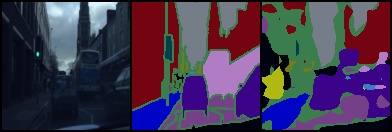

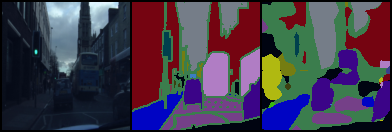

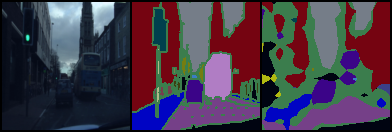

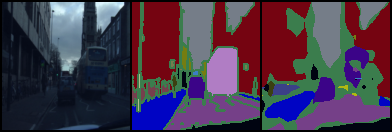

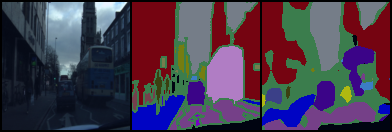

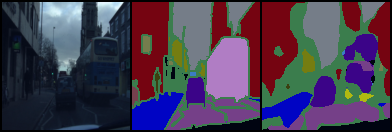

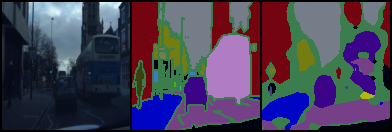

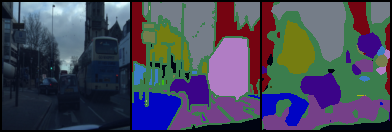

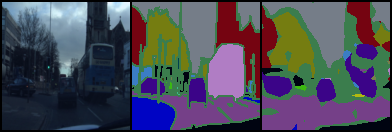

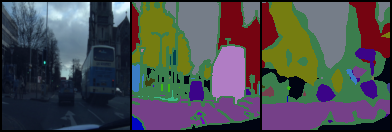

In [16]:
for i in range(10):
    display(Image.open(f'results/{i:03d}.png'))